In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import os


In [2]:
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CropDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for idx, cls in enumerate(self.classes)}

        # Initialize the list to store image paths and labels
        self.samples = []

        # Iterate through each class folder
        for cls in self.classes:
            class_path = os.path.join(root_dir, cls)
            if os.path.isdir(class_path):
                for img in os.listdir(class_path):
                    path = os.path.join(class_path, img).replace('\\\\', '/').replace('\\', '/')
                    path = os.path.normpath(path)
                    if os.path.exists(path):
                        self.samples.extend([(path, cls)])
                

    def __len__(self):
        return len(self.samples)
    
    def displayImage(self, idx):
        img_path, folder_name = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        display(img)
        # plt.imshow(img)
        # plt.axis('off')
        # plt.show()

    
    def getItemVerbose(self, idx, displayImage=False):
        if displayImage:
            self.displayImage(idx)
            
        img, one_hot_label = self[idx]
        img_path, label = self.samples[idx]
        return img_path, one_hot_label, label


    def __getitem__(self, idx):
        img_path, folder_name = self.samples[idx]

        # Open the image using PIL
        img = Image.open(img_path).convert("RGB")

        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        class_idx = self.class_to_idx[folder_name]
        one_hot_label = torch.nn.functional.one_hot(torch.tensor(class_idx), num_classes=len(self.classes))

        return img, one_hot_label

In [3]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to [0, 1]
        ])


source_path_train = 'D:/Rutgers/ExtraProjects/HackPrinceton23/HackPrinceton23/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
source_path_valid = 'D:/Rutgers/ExtraProjects/HackPrinceton23/HackPrinceton23/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

# Replace 'path/to/your/dataset' with the actual path to your dataset
train_dataset = CropDiseaseDataset(root_dir=source_path_train, transform=transform)
valid_dataset = CropDiseaseDataset(root_dir=source_path_valid, transform=transform)

print("Train Dataset Total Size: ", len(train_dataset))
print("Validation Dataset Total Size: ", len(valid_dataset))


Train Dataset Total Size:  69877
Validation Dataset Total Size:  17477


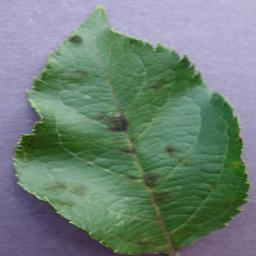

Sample Image Path:  D:\Rutgers\ExtraProjects\HackPrinceton23\HackPrinceton23\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train\Apple___Apple_scab\00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG
Sample Label:  Apple___Apple_scab
Sample One Hot:  tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [4]:
# Visualize a sample from the training dataset

img_path, one_hot_label, label = train_dataset.getItemVerbose(0, displayImage=True)
print("Sample Image Path: ", img_path)
print("Sample Label: ", label)
print("Sample One Hot: ", one_hot_label)

## Now, let's build a classification model by fine-tuning ResNet

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not torch.cuda.is_available(): print("WARNING: Model will run extremely slow on cpu")

In [6]:
import torch.nn.functional as F
from transformers import AutoFeatureExtractor, AutoModel

class ResNetClassifer(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifer, self).__init__()
        self.num_classes = num_classes

        # Use a pre-trained ResNet model from Hugging Face
        self.resnet_model = AutoModel.from_pretrained("microsoft/resnet-50")

        # Fully connected layers for embedding
        self.fc = nn.Sequential(
            nn.Linear(2048, self.num_classes),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Forward pass for one input
        x = self.resnet_model(x)
        x = x.pooler_output.squeeze()

        if len(x.shape) == 1:
          # If it's a single input add a batch dimension
          x = x.unsqueeze(0)

        x = self.fc(x)
        return x

In [20]:
def accuracy(predictions, labels):
    # Convert the predictions to class indices
    _, predicted_classes = predictions.max(1)
    
    # Convert one-hot encoded labels to class indices
    _, true_classes = labels.max(1)

    # Calculate accuracy
    correct_predictions = (predicted_classes == true_classes).sum().item()
    total_samples = labels.size(0)
    acc = correct_predictions / total_samples
    
    return acc

In [21]:
# Hyperparamters
batch_size = 32
num_classes = len(one_hot_label)
learning_rate = 0.0001

In [22]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

ResNetClassifer = ResNetClassifer(num_classes).to(device)

AttributeError: 'int' object has no attribute 'shape'

In [23]:
optimizer = optim.Adam(ResNetClassifer.parameters(), lr=learning_rate)

# Define cross entropy loss
criterion = nn.CrossEntropyLoss()
loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

# Training Loop
num_epochs = 3
for epoch in range(num_epochs):

    # Create a tqdm progress bar for the training loader
    train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for batch in train_loader_iter:
        x, y = [th.to(device) for th in batch]
        optimizer.zero_grad()
        x = ResNetClassifer(x)
        loss = criterion(x, y.float())
        acc = accuracy(x, y.float())
        train_accuracy_list.append(acc)
        loss.backward()
        optimizer.step()
        train_loader_iter.set_postfix({'Loss': loss.item()})
        train_loader_iter.set_postfix({'Acc': acc})

    # Validation loop
    with torch.no_grad():
        total_validation_loss = 0.0
        num_batches = 0
        for batch in validation_loader:
            x, y = [th.to(device) for th in batch]
            optimizer.zero_grad()
            x = ResNetClassifer(x)
            validation_loss = criterion(x, y.float())
            total_validation_loss += validation_loss.item()
            num_batches += 1
        average_validation_loss = total_validation_loss / num_batches

    epoch_train_accuracy = torch.stack(train_accuracy_list).mean()
    epoch_val_accuracy = torch.stack(val_accuracy_list).mean()
    train_accuracy_list = []
    val_accuracy_list = []
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {epoch_train_accuracy}, Validation Loss: {average_validation_loss}, Val. Accuracy: {epoch_val_accuracy}')
    loss_list.append(loss.item())
    val_loss_list.append(average_validation_loss)

KeyboardInterrupt: 